In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14



In [2]:
import numpy as np
import pandas as pd
from collections import namedtuple
import os
import glob
from pathlib import Path

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

In [70]:
from torchsummary import summary

In [4]:
from pymono.aux_func import select_image_files, select_image_and_metadata, energy
from pymono.aux_func import select_image_and_lbl, get_energy, get_means_stds
from pymono.aux_func import mean_rms, weighted_mean_and_sigma, energy_h3d, corrected_energy

In [5]:
from pymono.plt_funcs import plot_true_positions, plot_images, plot_energies, plot_corrected_energy
from pymono.plt_funcs import  plot_true_predicted, plotxyz, plotxyze, plot_h3d, plot_energies2, plot_loss
from pymono.plt_funcs import plot_images_ds, histoplot, plot_image_ds, plot_images_ds, plot_image

In [6]:
from pymono.cnn_func import single_run, CNN_basic, CNN_3x3,train_cnn, evaluate_cnn

In [7]:
from pymono.cnn_func import ResNet10

In [8]:
from pymono.mono_dl import MonoDataset, files_list_npy_csv,mono_data_loader

In [9]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [10]:
data_dir = Path(os.environ['MONOLITH_DATA'])

In [11]:
crystal = os.path.join(data_dir,"CsI_4x4_fullwrap_50k_2MHzDC_PTFE_LUT_fano_NX")

In [12]:
crystal

'/home/investigator/Data/monolithic_csi/CsI_4x4_fullwrap_50k_2MHzDC_PTFE_LUT_fano_NX'

# CsI_4x4_fullwrap_50k_0MHzDC_PTFE_LUT_NX

- CsI crystal assumed cold (100 k hot/MeV)

#### Parameters
- 4x4 SiPMs, thus 12x12 matrix
- 50 k photons per point (BGO, with ~9 k photons/MeV)
- 0MHzDC 
- PTFE wrapping (all sides)
- LUT model
- Nexus simulation
- new data format (x,y,z,E)

### Short
- Consider only positions (not energy)

## Setup

In [13]:
files_list_npy_csv(crystal)

('images',
 'metadata',
 array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
         53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
         66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
         79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100]))

In [14]:
imgs, mdata = select_image_and_lbl(crystal, 3)

Selected files: img = images_4.npy, metdata = metadata_4.csv


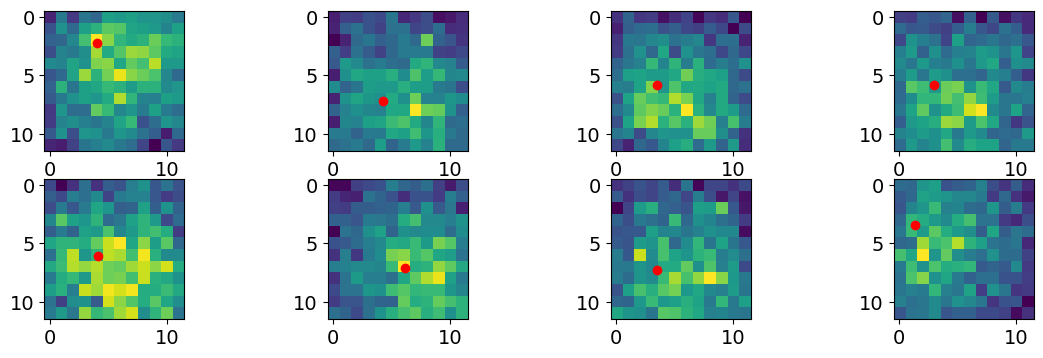

In [15]:
plot_images(imgs, mdata, range(0,8))

In [16]:
imgs[0]

array([[34., 54., 38., 53., 49., 65., 63., 65., 62., 62., 60., 55.],
       [44., 61., 50., 65., 70., 77., 76., 66., 65., 63., 57., 65.],
       [48., 49., 58., 74., 94., 82., 71., 68., 70., 79., 72., 70.],
       [43., 57., 54., 60., 85., 68., 76., 84., 83., 77., 68., 66.],
       [59., 57., 66., 61., 81., 82., 67., 78., 74., 87., 63., 63.],
       [45., 50., 66., 84., 70., 80., 92., 82., 79., 75., 58., 50.],
       [48., 70., 53., 65., 67., 72., 70., 64., 70., 70., 59., 62.],
       [46., 54., 61., 65., 62., 68., 86., 71., 57., 56., 65., 63.],
       [38., 62., 51., 51., 78., 72., 58., 62., 55., 65., 55., 51.],
       [39., 57., 60., 56., 53., 57., 66., 72., 44., 51., 62., 58.],
       [46., 61., 43., 62., 61., 54., 62., 59., 52., 47., 32., 50.],
       [34., 32., 40., 53., 56., 59., 54., 51., 41., 27., 45., 38.]],
      dtype=float32)

In [17]:
np.mean(imgs[0])

61.11111

In [18]:
np.std(imgs[0])

12.989906

In [19]:
energy = get_energy(crystal, 9)

Selected files: img = images_10.npy, metdata = metadata_10.csv


In [20]:
energy

array([8764., 8913., 8846., ..., 8615., 8792., 8880.], dtype=float32)

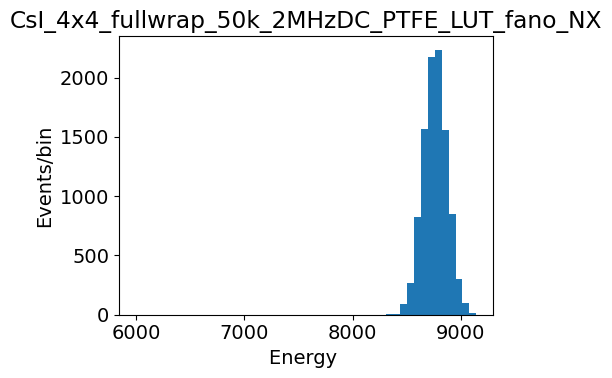

In [21]:
plot_energies2({"CsI_4x4_fullwrap_50k_2MHzDC_PTFE_LUT_fano_NX":energy}, xmin=6000, xmax=max(energy),num_bins = 50)

In [22]:
mean6x6, std6x6, fwhm6x6 = mean_rms(energy)

print(f"mean = {mean6x6:.2f} sigma = {100*std6x6:.2f} % FWHM = {100*fwhm6x6:.2f} %")

mean = 8761.34 sigma = 1.26 % FWHM = 2.90 %


## Short run
- Use a fraction (1/3) of data set.
- No normalization

In [23]:
first_file = 0  # initial file indx
last_file  = 30  # lasta file indx
batch_size = 1000  # Batch size
train_fraction=0.7 
val_fraction=0.2


In [24]:
# xyze = True for new data sets where the csv includes (x,y,z,nphot) but the network 
# compares with xyz. For old data sets (x,y,z) or new data sets comparing with a net of
# x,y,z,e output, use xyze = False (or remove, it is the default). 

dataset = MonoDataset(crystal, first_file, last_file, xyze=True)  # No comparison with energy only xyz


Running Monoataset with norm = False, resize=False, xyze=True
Loading files with indexes: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
meta[1:-1] =[-17.736462   5.652053  14.491894]


In [25]:
data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)

Loaded 300000 events
 train size = 210000
 val size = 60000
 test size = 30000
 train indices = range(0, 210000)
 val indices = range(210000, 270000)
 test indices = range(270000, 300000)
210000 training events (70.0%)
60000 validation events (20.0%)
30000 test events (10.0%)


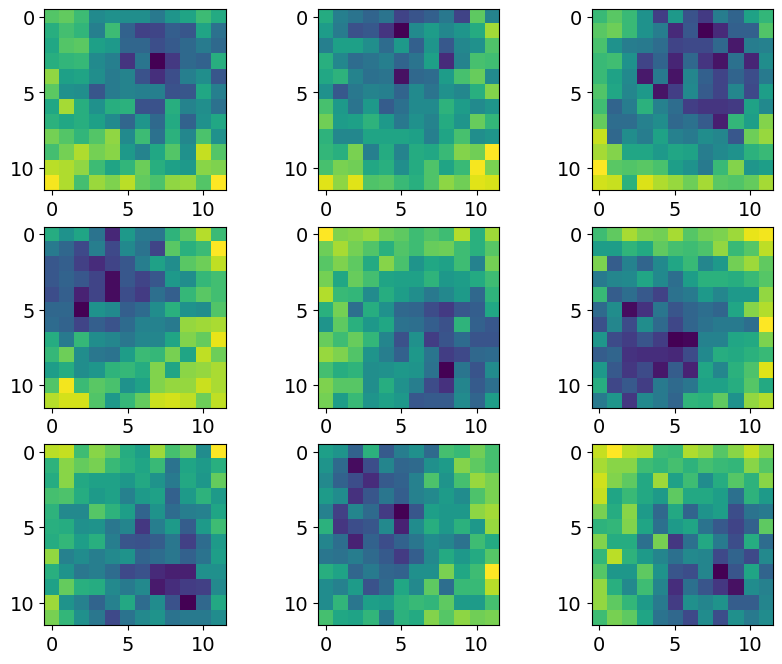

In [26]:
plot_images_ds(dataset, imgs=(0,9), sx=3, figsize=(10, 8))

In [27]:
for images, positions in train_loader:
    print(images.size())
    print(positions.size())
    print(images[0,0,:,:])
    break

torch.Size([1000, 1, 12, 12])
torch.Size([1000, 3])
tensor([[29., 42., 49., 57., 54., 77., 80., 60., 76., 70., 65., 61.],
        [42., 54., 53., 67., 72., 76., 65., 92., 69., 90., 83., 80.],
        [53., 56., 52., 60., 73., 80., 74., 66., 87., 94., 67., 63.],
        [48., 54., 66., 54., 64., 81., 75., 86., 85., 87., 68., 54.],
        [47., 68., 62., 70., 83., 72., 79., 90., 86., 81., 72., 77.],
        [32., 54., 61., 68., 86., 62., 75., 88., 74., 75., 62., 74.],
        [54., 48., 55., 72., 76., 80., 75., 75., 68., 75., 72., 53.],
        [45., 56., 52., 57., 60., 72., 62., 79., 77., 67., 64., 55.],
        [34., 44., 59., 47., 56., 68., 71., 73., 73., 66., 57., 49.],
        [28., 56., 49., 56., 61., 58., 53., 60., 65., 58., 47., 39.],
        [36., 39., 49., 42., 56., 52., 54., 62., 43., 53., 64., 47.],
        [33., 31., 49., 41., 29., 51., 61., 50., 42., 46., 35., 38.]])


### Define CNN

In [49]:
def image_shape_after_conv(I, P, K, S):
    """
    I: shape (1d) of input image
    P: Padding
    K: Kernel size
    S: stride
    """
    return ((I + 2*P - (K-1) -1)/S +1)
    

In [62]:
def image_evolution_cnn3x3(input, chi=64):
    """
    input : input image
    """

    def doconv(i, conv, nconv):
        i1 = conv(i)
        print(f"shape of image after convolution {nconv:} = {i1.shape}")
        i2 = pool(i1)
        print(f"shape of image after pool {nconv:}= {i2.shape}")
        return i2
        
    conv1 = nn.Conv2d(1, chi, 3, padding=1) # chin =1, chout=64, kernel=3x3 P=1 (S=1)
    conv2 = nn.Conv2d(chi, chi*2, 3, padding=1)
    conv3 = nn.Conv2d(chi*2, chi*4, 2, padding=1)
    conv4 = nn.Conv2d(chi*4, chi*8, 2, padding=1)
    pool  = nn.MaxPool2d(2, stride=2)  # K=2, S=2

    print(f"shape of input image = {input.shape}")

    i1 = doconv(input, conv1, 1) 
    i2 = doconv(i1, conv2, 2)
    i3 = doconv(i2, conv3, 3)
    i4 = doconv(i3, conv4, 4)

    print(f"shape of out image = {i4.shape}")
    

    


In [64]:
def image_evolution_cnn_basic(input, chi=128):
    """
    input : input image
    """

    def doconv(i, conv, nconv):
        i1 = conv(i)
        print(f"shape of image after convolution {nconv:} = {i1.shape}")
        i2 = pool(i1)
        print(f"shape of image after pool {nconv:}= {i2.shape}")
        return i2
        
    conv1 = nn.Conv2d(1, chi, 3, padding=1) # chin =1, chout=64, kernel=3x3 P=1 (S=1)
    conv2 = nn.Conv2d(chi, chi*2, 2, padding=1)
    conv3 = nn.Conv2d(chi*2, chi*4, 2, padding=1)
    pool  = nn.MaxPool2d(2, stride=2)  # K=2, S=2

    print(f"shape of input image = {input.shape}")

    i1 = doconv(input, conv1, 1) 
    i2 = doconv(i1, conv2, 2)
    i3 = doconv(i2, conv3, 3)

    print(f"shape of out image = {i3.shape}")

In [53]:
input = torch.randn(1, 1, 8, 8)  # batch = 1, channel=1, 8x8

In [63]:
image_evolution_cnn3x3(input, chi=64)

shape of input image = torch.Size([1, 1, 8, 8])
shape of image after convolution 1 = torch.Size([1, 64, 8, 8])
shape of image after pool 1= torch.Size([1, 64, 4, 4])
shape of image after convolution 2 = torch.Size([1, 128, 4, 4])
shape of image after pool 2= torch.Size([1, 128, 2, 2])
shape of image after convolution 3 = torch.Size([1, 256, 3, 3])
shape of image after pool 3= torch.Size([1, 256, 1, 1])
shape of image after convolution 4 = torch.Size([1, 512, 2, 2])
shape of image after pool 4= torch.Size([1, 512, 1, 1])
shape of out image = torch.Size([1, 512, 1, 1])


In [65]:
image_evolution_cnn_basic(input, chi=128)

shape of input image = torch.Size([1, 1, 8, 8])
shape of image after convolution 1 = torch.Size([1, 128, 8, 8])
shape of image after pool 1= torch.Size([1, 128, 4, 4])
shape of image after convolution 2 = torch.Size([1, 256, 5, 5])
shape of image after pool 2= torch.Size([1, 256, 2, 2])
shape of image after convolution 3 = torch.Size([1, 512, 3, 3])
shape of image after pool 3= torch.Size([1, 512, 1, 1])
shape of out image = torch.Size([1, 512, 1, 1])


In [73]:
class CNN_basic(nn.Module):
    """
    Defines a convolutional network with a basic architecture:
    convolution (3x3) , reLU batch norm and MaxPool: (8,8,1) => (4,4,128)
    convolution (2x2) , reLU batch norm and MaxPool: (4,4,128) => (2,2,256)
    convolution (2x2) , reLU batch norm and MaxPool: (2,2,256) => (1,1,512)
    drop (optional) 
    linear layer 512 => 3

    Input to the network are the pixels of the pictures, output (x,y,z)

    """
    def __init__(self, chi=128, dropout=False, dropout_fraction=0.2, energy=False):
        super().__init__()
        self.dropout = dropout
        self.conv1 = nn.Conv2d(1, chi, 3, padding=1) 
        self.bn1   = nn.BatchNorm2d(chi)
        self.conv2 = nn.Conv2d(chi, chi*2, 2, padding=1)
        self.bn2   = nn.BatchNorm2d(chi*2)
        self.conv3 = nn.Conv2d(chi*2, chi*4, 2, padding=1)
        self.bn3   = nn.BatchNorm2d(chi*4)
        self.pool = nn.MaxPool2d(2, 2)
        if energy:
            self.fc0 = nn.Linear(chi*4, 4) # add energy output.
        else:
            self.fc0 = nn.Linear(chi*4, 3)
        self.drop1 = nn.Dropout(p=dropout_fraction)
        self.debug = True

 
    def forward(self, x):

        if(self.debug): print(f"input data shape =>{x.shape}")
        # convolution (3x3) , reLU batch norm and MaxPool: (8,8,1) => (4,4,128)
        x = self.pool(self.bn1(F.leaky_relu(self.conv1(x))))
        
        if(self.debug): print(f"(8,8,1) => (4,4,128) =>{x.shape}")
        # convolution (2x2) , reLU batch norm and MaxPool: (4,4,128) => (2,2,256)
        x = self.pool(self.bn2(F.leaky_relu(self.conv2(x))))
        
        if(self.debug): print(f"(4,4,128) => (2,2,256) =>{x.shape}")
        # convolution (2x2) , reLU batch norm and MaxPool: (2,2,256) => (1,1,512)
        x = self.pool(self.bn3(F.leaky_relu(self.conv3(x))))
        
        if(self.debug): print(f"(2,2,256) => (1,1,512) =>{x.shape}")
        x = x.flatten(start_dim=1)
        # Flatten
        
        if(self.debug): print(f"(1,1,512) => (1,1,3) =>{x.shape}")
        
        if self.dropout: x = self.drop1(x)  # drop
        
        x = self.fc0(x)    # linear layer 512 => 3 (4)
        
        if(self.debug): print(x.shape)

        self.debug = False

        return x

In [66]:
class CNN_3x3(nn.Module):
    """
    Defines a convolutional network with a basic architecture:
    convolution (3x3) , reLU batch norm and MaxPool: (12,12,1) => (12,12,64)
    convolution (2x2) , reLU batch norm and MaxPool: (12,12,64) => (6,6,128)
    convolution (2x2) , reLU batch norm and MaxPool: (6,6,128) => (3,3,256)
    convolution (1x1) , reLU batch norm and MaxPool: (2,2,256) => (1,1,512)
    drop (optional) 
    linear layer 512 => 3

    Input to the network are the pixels of the pictures, output (x,y,z)

    """
    def __init__(self, chi=64, dropout=False, dropout_fraction=0.2, energy=False):
        super().__init__()
        self.dropout = dropout
        self.conv1 = nn.Conv2d(1, chi, 3, padding=1) 
        self.bn1   = nn.BatchNorm2d(chi)
        self.conv2 = nn.Conv2d(chi, chi*2, 3, padding=1)
        self.bn2   = nn.BatchNorm2d(chi*2)
        self.conv3 = nn.Conv2d(chi*2, chi*4, 2, padding=1)
        self.bn3   = nn.BatchNorm2d(chi*4)
        self.conv4 = nn.Conv2d(chi*4, chi*8, 2, padding=1)
        self.bn4   = nn.BatchNorm2d(chi*8)
        self.pool = nn.MaxPool2d(2, 2)
        if energy:
            self.fc0 = nn.Linear(chi*8, 4) # add output for energy
        else:
            self.fc0 = nn.Linear(chi*8, 3)
        self.drop1 = nn.Dropout(p=dropout_fraction)
        self.debug = True

    def forward(self, x):

        if(self.debug): print(f"input data shape =>{x.shape}")
        # convolution (3x3) , reLU batch norm and MaxPool: (8,8,1) => (4,4,64)
        if(self.debug): print(f"(8,8,1) => (4,4,64) =>{x.shape}")
        x = self.pool(self.bn1(F.leaky_relu(self.conv1(x))))

        if(self.debug): print(f"(4,4,64) => (2,2,128) =>{x.shape}")
        # convolution (2x2) , reLU batch norm and MaxPool: (8,8,64) => (4,4,128)
        x = self.pool(self.bn2(F.leaky_relu(self.conv2(x))))
        
        if(self.debug): print(f"(2,2,128) => (1,1,256) =>{x.shape}")
        # convolution (2x2) , reLU batch norm and MaxPool: (4,4,128) => (2,2,256)
        x = self.pool(self.bn3(F.leaky_relu(self.conv3(x))))
        
        if(self.debug): print(f"(1,1,256) => (1,1,512) =>{x.shape}")
        # convolution (2x2) , reLU batch norm and MaxPool: (2,2,256) => (1,1,512)
        x = self.pool(self.bn4(F.leaky_relu(self.conv4(x))))
        
        #if(self.debug): print(f"(2,2,256) => (1,1,512) =>{x.shape}")
        if(self.debug): print(f"(1,1,512) => (1,1,3) =>{x.shape}")
        x = x.flatten(start_dim=1)
        # Flatten
        
        if self.dropout: x = self.drop1(x)  # drop
        
        x = self.fc0(x)    # linear layer 512 => 3
        
        if(self.debug): print(x.shape)

        self.debug = False

        return x

In [67]:
# Load the model. Be careful to set energy to false if using conventional CNN (just positions)
model = CNN_3x3(dropout=False, energy=False).to(device)  
print(model)

CNN_3x3(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc0): Linear(in_features=512, out_features=3, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
)


In [72]:
summary(model,(1,8,8))

input data shape =>torch.Size([2, 1, 8, 8])
(8,8,1) => (4,4,64) =>torch.Size([2, 1, 8, 8])
(4,4,64) => (2,2,128) =>torch.Size([2, 64, 4, 4])
(2,2,128) => (1,1,256) =>torch.Size([2, 128, 2, 2])
(1,1,256) => (1,1,512) =>torch.Size([2, 256, 1, 1])
(1,1,512) => (1,1,3) =>torch.Size([2, 512, 1, 1])
torch.Size([2, 3])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 8, 8]             640
       BatchNorm2d-2             [-1, 64, 8, 8]             128
         MaxPool2d-3             [-1, 64, 4, 4]               0
            Conv2d-4            [-1, 128, 4, 4]          73,856
       BatchNorm2d-5            [-1, 128, 4, 4]             256
         MaxPool2d-6            [-1, 128, 2, 2]               0
            Conv2d-7            [-1, 256, 3, 3]         131,328
       BatchNorm2d-8            [-1, 256, 3, 3]             512
         MaxPool2d-9            [-1, 256, 1, 

In [75]:
modelb = CNN_basic(dropout=False, energy=False).to(device)  
print(modelb)

CNN_basic(
  (conv1): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 512, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc0): Linear(in_features=512, out_features=3, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
)


In [76]:
summary(modelb,(1,8,8))

input data shape =>torch.Size([2, 1, 8, 8])
(8,8,1) => (4,4,128) =>torch.Size([2, 128, 4, 4])
(4,4,128) => (2,2,256) =>torch.Size([2, 256, 2, 2])
(2,2,256) => (1,1,512) =>torch.Size([2, 512, 1, 1])
(1,1,512) => (1,1,3) =>torch.Size([2, 512])
torch.Size([2, 3])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 128, 8, 8]           1,280
       BatchNorm2d-2            [-1, 128, 8, 8]             256
         MaxPool2d-3            [-1, 128, 4, 4]               0
            Conv2d-4            [-1, 256, 5, 5]         131,328
       BatchNorm2d-5            [-1, 256, 5, 5]             512
         MaxPool2d-6            [-1, 256, 2, 2]               0
            Conv2d-7            [-1, 512, 3, 3]         524,800
       BatchNorm2d-8            [-1, 512, 3, 3]           1,024
         MaxPool2d-9            [-1, 512, 1, 1]               0
           Linear-10              

In [37]:
# Set up the optimizer and loss function.
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()


In [38]:
single_run(train_loader, device, model, optimizer,criterion)

** Run for 1 event**
epoch = 0
i = 0
images = torch.Size([1000, 1, 4, 4])
labels = torch.Size([1000, 3])
input data shape =>torch.Size([1000, 1, 4, 4])
(8,8,1) => (8,8,64) =>torch.Size([1000, 1, 4, 4])
(8,8,64) => (4,4,128) =>torch.Size([1000, 64, 2, 2])
(4,4,128) => (2,2,256) =>torch.Size([1000, 128, 1, 1])
(2,2,256) => (1,1,512) =>torch.Size([1000, 256, 1, 1])
(1,1,512) => (1,1,3) =>torch.Size([1000, 512, 1, 1])
torch.Size([1000, 3])
outputs = torch.Size([1000, 3])
Train Step 1/210, Loss: 97.90762329101562
i = 1
images = torch.Size([1000, 1, 4, 4])
labels = torch.Size([1000, 3])
outputs = torch.Size([1000, 3])
Train Step 2/210, Loss: 71.39328002929688


In [39]:
epochs = 10

In [40]:
train_losses, val_losses = train_cnn(train_loader, val_loader,
                                    model, optimizer, device, criterion, 
                                    batch_size, epochs=epochs, iprnt=200)

Training with  ->210000 images
size of train loader  ->210 images
Evaluating with  ->60000 images
size of eval loader  ->60 images
Running for epochs ->10

EPOCH 0
Train Step 200/210, Loss: 30.107173919677734
--- EPOCH 0 AVG TRAIN LOSS: 31.10742816925049
--- EPOCH 0 AVG VAL LOSS: 30.43898210525513

EPOCH 1
Train Step 200/210, Loss: 30.07224464416504
--- EPOCH 1 AVG TRAIN LOSS: 30.45735267457508
--- EPOCH 1 AVG VAL LOSS: 30.56672372817993

EPOCH 2
Train Step 200/210, Loss: 30.682167053222656
--- EPOCH 2 AVG TRAIN LOSS: 30.445299366542272
--- EPOCH 2 AVG VAL LOSS: 32.390232721964516

EPOCH 3
Train Step 200/210, Loss: 29.815614700317383
--- EPOCH 3 AVG TRAIN LOSS: 30.393046333676292
--- EPOCH 3 AVG VAL LOSS: 30.492387549082437

EPOCH 4
Train Step 200/210, Loss: 31.292692184448242
--- EPOCH 4 AVG TRAIN LOSS: 30.391579845973425
--- EPOCH 4 AVG VAL LOSS: 30.4895424524943

EPOCH 5
Train Step 200/210, Loss: 30.171112060546875
--- EPOCH 5 AVG TRAIN LOSS: 30.406918689182827
--- EPOCH 5 AVG VAL L

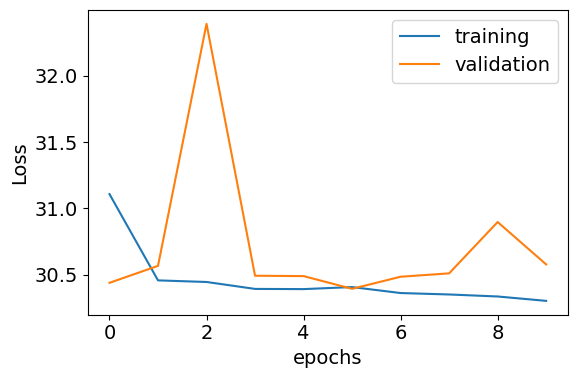

In [41]:
plot_loss(epochs, train_losses, val_losses,figsize=(6, 4))


In [42]:
tdeltas = evaluate_cnn(test_loader, model, device, energy=False)

In [36]:
#plot_true_predicted(tdeltas, nbins = 50)

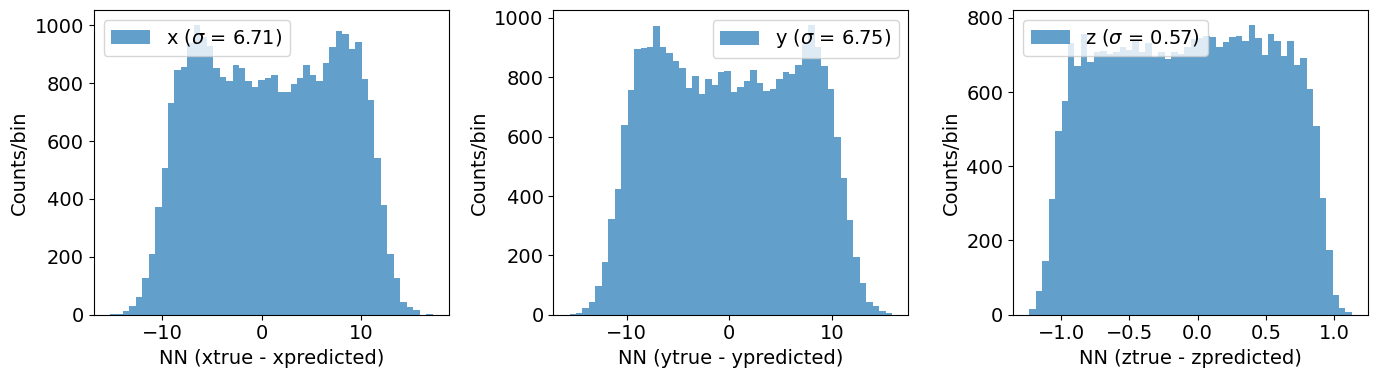

In [43]:
plotxyz(tdeltas, nbins=50)

In [42]:
#plotxyze(tdeltas, nbins=50)

## Normalization

In [44]:
means, stds = get_means_stds(dir=crystal)

files in dir: 100
shape -> (10000, 4, 4)
mean img0 =441.25
std  img0 =29.448047637939453


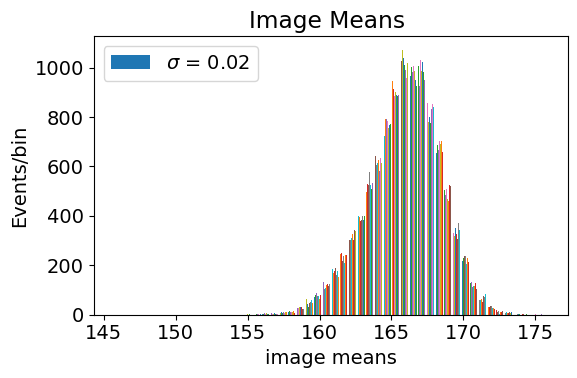

In [39]:
histoplot(means, "image means", vart="Image Means ", num_bins = 50, figsize=(6, 4))

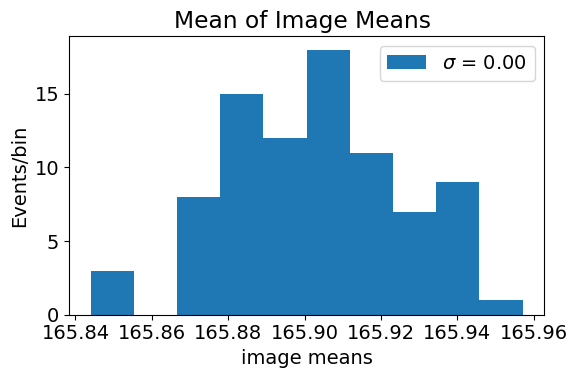

In [40]:
meansx =[np.mean(x) for x in means]
histoplot(meansx, "image means", vart="Mean of Image Means ", num_bins = 10, figsize=(6, 4))

In [41]:
imean = np.mean(meansx)

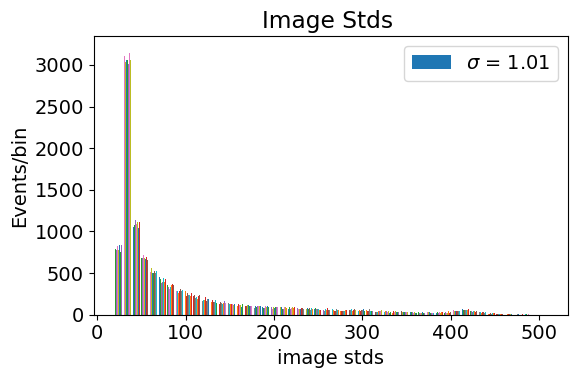

In [42]:
histoplot(stds, "image stds", vart="Image Stds ", num_bins = 50, figsize=(6, 4))

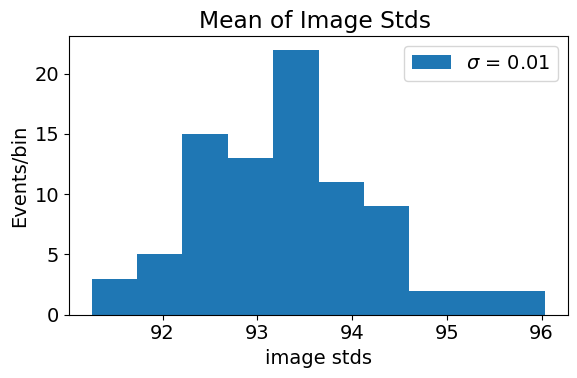

In [43]:
stdsx =[np.std(x) for x in stds]
histoplot(stdsx, "image stds", vart="Mean of Image Stds ", num_bins = 10, figsize=(6, 4))

In [44]:
isigma = np.mean(stdsx)

In [45]:
print(f"Normalization: mean = {imean}, std = {isigma}")

Normalization: mean = 165.9029541015625, std = 93.34273529052734


### Run with full stats and normalization 

In [46]:
first_file = 0  # initial file indx
last_file  = 100  # lasta file indx
batch_size = 1000  # Batch size
train_fraction=0.7 
val_fraction=0.2

In [47]:
dataset = MonoDataset(crystal, first_file, last_file, norm=True, resize=False, mean=imean, std=isigma,xyze=False)  # No comparison with energy only xyz



Running Monoataset with norm = True, resize=False, xyze=False
Loading files with indexes: [  1   2   3   4  20  21  22  23  24  25  26  27  28  29  30  31  32  33
  34  35  36  37  38  39  40  41  42  43  44  45  46  47  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100]


In [48]:
 data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)   
    

Loaded 840000 events
 train size = 588000
 val size = 168000
 test size = 84000
 train indices = range(0, 588000)
 val indices = range(588000, 756000)
 test indices = range(756000, 840000)
588000 training events (70.0%)
168000 validation events (20.0%)
84000 test events (10.0%)


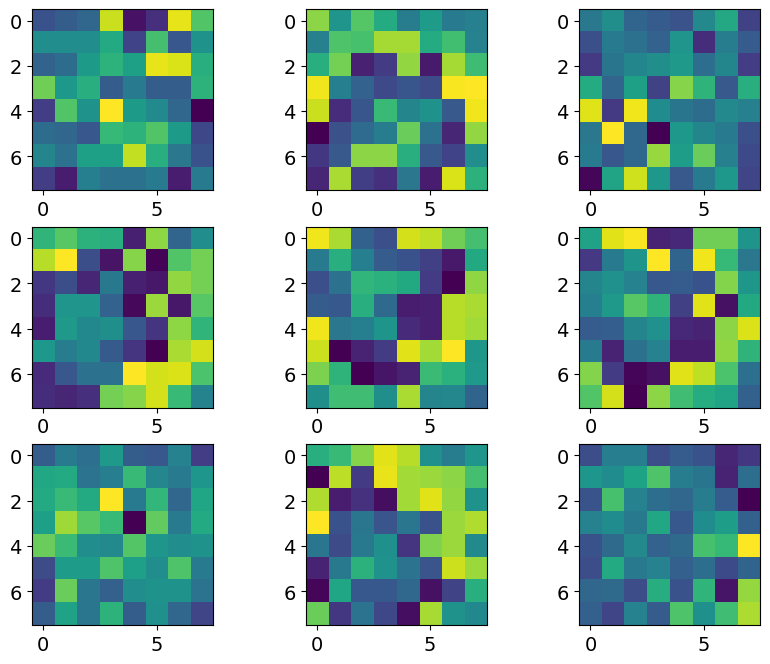

In [49]:
plot_images_ds(dataset, imgs=(0,9), sx=3, figsize=(10, 8))

In [50]:
model = CNN_3x3(dropout=False, energy=False).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [51]:
train_losses, val_losses = train_cnn(train_loader, val_loader,
                                    model, optimizer, device, criterion, 
                                    batch_size, epochs=20, iprnt=200)

Training with  ->588000 images
size of train loader  ->588 images
Evaluating with  ->168000 images
size of eval loader  ->168 images
Running for epochs ->20

EPOCH 0
input data shape =>torch.Size([1000, 1, 8, 8])
(8,8,1) => (8,8,64) =>torch.Size([1000, 1, 8, 8])
(8,8,64) => (4,4,128) =>torch.Size([1000, 64, 4, 4])
(4,4,128) => (2,2,256) =>torch.Size([1000, 128, 2, 2])
(2,2,256) => (1,1,512) =>torch.Size([1000, 256, 1, 1])
(1,1,512) => (1,1,3) =>torch.Size([1000, 512, 1, 1])
torch.Size([1000, 3])
Train Step 200/588, Loss: 5.749087333679199
Train Step 400/588, Loss: 5.467091083526611
--- EPOCH 0 AVG TRAIN LOSS: 14.66670837491548
--- EPOCH 0 AVG VAL LOSS: 4.823986022245316

EPOCH 1
Train Step 200/588, Loss: 5.361299514770508
Train Step 400/588, Loss: 4.359795570373535
--- EPOCH 1 AVG TRAIN LOSS: 4.454578836758931
--- EPOCH 1 AVG VAL LOSS: 4.223247756560643

EPOCH 2
Train Step 200/588, Loss: 4.015566825866699
Train Step 400/588, Loss: 4.30186128616333
--- EPOCH 2 AVG TRAIN LOSS: 4.17137938

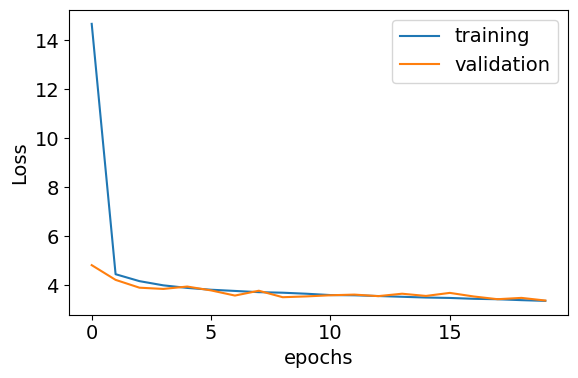

In [52]:
plot_loss(20, train_losses, val_losses,figsize=(6, 4))


In [53]:
tdeltas = evaluate_cnn(test_loader, model, device, pixel_size = 6, energy=False)


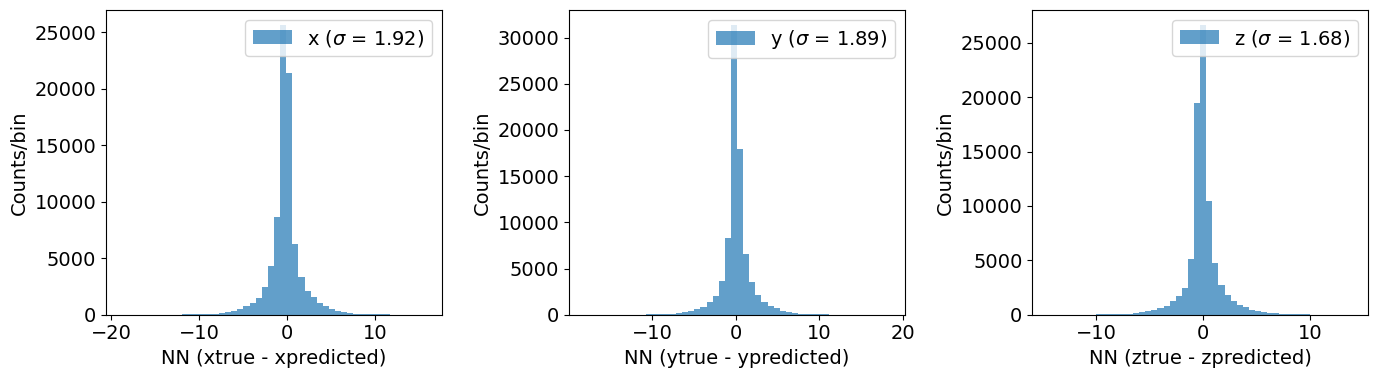

In [54]:
plotxyz(tdeltas, nbins=50)

### Deeper network

In [55]:
class ResBlock(nn.Module):
    """
    Implements a residual block consisting in [Conv2d->BatchNorm2d->ReLU] + 
    [Conv2d->BatchNorm2d]. This residual is added to the input (then a second activation ReLU applied)
    
    If downsample = None (e.g, default first pass), then we obtain f(x) + x where 
    f(x) -> [Conv2d->BatchNorm2d->ReLU ->Conv2d->BatchNorm2d]. Otherwise the block is skipped. 
    
    """
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                                  stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                                  stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x # This is the residual (in the case of no downsample)
        out = self.conv1(x)
        out = self.conv2(out)
        
        if self.downsample:  # this is the residual in the case of downsample
            residual = self.downsample(x)
            
        out += residual # This is it! f(x) + x 
        out = self.relu(out)

        return out

In [56]:
class ResNet10(nn.Module):
    """
    Implements the Residual Network with 34 layers:
    The architecture is like this:
    1. Image passes through a convolution (kernel 3x3) 
    with stride = 1 and padding = 1 which increases the features from 3 to 64 and 
    preserves spatian dimensions, then batch normalization and activation. 
    # (W,H,1) => (W,H,64)
    
    2. The layer architecture is as follows (with a skip connection between each pair of layers) 
        6 layers of convolution 3x3 with 64 features
        8 layers of convolution 3x3 with 128 features (max pool 56 -> 28)
        12 layers of convolution 3x3 with 256 features (max pool 28 -> 24)
        6 layers of convolution 3x3 with 512 features (max pool 14 -> 7)
    3. Then avgpool and fc.
    
    """
    def __init__(self, block, num_classes = 3, dropout=False, dropout_fraction=0.2, debug=False):
        super(ResNet10, self).__init__()
        self.debug = debug
        self.inplanes = 64

        self.conv1 = nn.Sequential(
                        nn.Conv2d(1, 64, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(2, 2)
        self.layer0 = self._make_layer(block, 64, 1, stride = 1, nlyr = 1)
        self.layer1 = self._make_layer(block, 128, 1, stride = 2, nlyr = 2)
        self.layer2 = self._make_layer(block, 256, 1, stride = 2, nlyr = 3)
        self.layer3 = self._make_layer(block, 512, 1, stride = 2, nlyr = 4)
        self.avgpool = nn.AvgPool2d(1, stride=1)
        self.fc = nn.Linear(512, num_classes)
        self.dropout = dropout
        self.drop1 = nn.Dropout(p=dropout_fraction)

           
    def _make_layer(self, block, planes, blocks, stride, nlyr):
        downsample = None
        
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        if self.debug:
            print(f" ## make_layer {nlyr}: planes = {planes},  blocks = {blocks}, stride = {stride}")
            print(f" ## make_layer: in_planes={self.inplanes}")
            print(f" ## make_layer: downsample = {downsample}")
            #print(f"layer block = 0: Block(in_channels={self.inplanes}, out_channels ={planes}, stride = {stride}, downsample = {downsample}")
            
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
            if self.debug:
                print(f" layer block = {i}: Block(in_channels={self.inplanes}, out_channels ={planes}, stride = 1, downsample = None")

        return nn.Sequential(*layers)
    
    def forward(self, x):
        if(self.debug): print(f" ResNet10: input data shape =>{x.shape}")
            
        x = self.conv1(x)
        if(self.debug): print(f" ResNet10: after conv1 =>{x.shape}")
            
        #x = self.maxpool(x)
        #if(self.debug): print(f" ResNet: after maxpool =>{x.shape}")
            
        x = self.layer0(x)
        if(self.debug): print(f" ResNet10: after layer0 =>{x.shape}")
        
        x = self.layer1(x)
        if(self.debug): print(f" ResNet10: after layer1 =>{x.shape}")
            
        x = self.layer2(x)
        if(self.debug): print(f" ResNet10: after layer2 =>{x.shape}")
            
        x = self.layer3(x)
        if(self.debug): print(f" ResNet10: after layer3 =>{x.shape}")
            
        x = self.avgpool(x)
        if(self.debug): print(f" ResNet10: after avgpool =>{x.shape}")

        x = x.flatten(start_dim=1)
        #x = x.view(x.size(0), -1)
        if(self.debug): print(f" ResNet10: after flatten =>{x.shape}")
        
        if self.dropout: x = self.drop1(x)  # drop
        x = self.fc(x)
        if(self.debug): print(f" ResNet10: after fc =>{x.shape}")

        self.debug = False
        return x
  

In [57]:
#define the model
model = ResNet10(ResBlock, debug=True).to(device)

 ## make_layer 1: planes = 64,  blocks = 1, stride = 1
 ## make_layer: in_planes=64
 ## make_layer: downsample = None
 ## make_layer 2: planes = 128,  blocks = 1, stride = 2
 ## make_layer: in_planes=64
 ## make_layer: downsample = Sequential(
  (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 ## make_layer 3: planes = 256,  blocks = 1, stride = 2
 ## make_layer: in_planes=128
 ## make_layer: downsample = Sequential(
  (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 ## make_layer 4: planes = 512,  blocks = 1, stride = 2
 ## make_layer: in_planes=256
 ## make_layer: downsample = Sequential(
  (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [58]:
print(model)

ResNet10(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
  )
  (layer1): Sequential(
    (0): ResBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-0

In [59]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [60]:
single_run(train_loader, device, model, optimizer,criterion)

** Run for 1 event**
epoch = 0
i = 0
images = torch.Size([1000, 1, 8, 8])
labels = torch.Size([1000, 3])
 ResNet10: input data shape =>torch.Size([1000, 1, 8, 8])
 ResNet10: after conv1 =>torch.Size([1000, 64, 8, 8])
 ResNet10: after layer0 =>torch.Size([1000, 64, 8, 8])
 ResNet10: after layer1 =>torch.Size([1000, 128, 4, 4])
 ResNet10: after layer2 =>torch.Size([1000, 256, 2, 2])
 ResNet10: after layer3 =>torch.Size([1000, 512, 1, 1])
 ResNet10: after avgpool =>torch.Size([1000, 512, 1, 1])
 ResNet10: after flatten =>torch.Size([1000, 512])
 ResNet10: after fc =>torch.Size([1000, 3])
outputs = torch.Size([1000, 3])
Train Step 1/588, Loss: 492.66265869140625
i = 1
images = torch.Size([1000, 1, 8, 8])
labels = torch.Size([1000, 3])
outputs = torch.Size([1000, 3])
Train Step 2/588, Loss: 443.7974548339844


In [61]:
data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)   
  

Loaded 840000 events
 train size = 588000
 val size = 168000
 test size = 84000
 train indices = range(0, 588000)
 val indices = range(588000, 756000)
 test indices = range(756000, 840000)
588000 training events (70.0%)
168000 validation events (20.0%)
84000 test events (10.0%)


In [62]:
train_losses, val_losses = train_cnn(train_loader, val_loader,
                                    model, optimizer, device, criterion, 
                                    batch_size=500, epochs=20, iprnt=200)

Training with  ->294000 images
size of train loader  ->588 images
Evaluating with  ->84000 images
size of eval loader  ->168 images
Running for epochs ->20

EPOCH 0
Train Step 200/588, Loss: 5.521753787994385
Train Step 400/588, Loss: 4.220992565155029
--- EPOCH 0 AVG TRAIN LOSS: 17.777941332787883
--- EPOCH 0 AVG VAL LOSS: 4.121632329055241

EPOCH 1
Train Step 200/588, Loss: 3.975870370864868
Train Step 400/588, Loss: 3.960501194000244
--- EPOCH 1 AVG TRAIN LOSS: 4.1327917782627805
--- EPOCH 1 AVG VAL LOSS: 3.962927524532591

EPOCH 2
Train Step 200/588, Loss: 3.787578821182251
Train Step 400/588, Loss: 3.633382797241211
--- EPOCH 2 AVG TRAIN LOSS: 3.861417579002121
--- EPOCH 2 AVG VAL LOSS: 4.512208373773666

EPOCH 3
Train Step 200/588, Loss: 3.726647138595581
Train Step 400/588, Loss: 4.116610527038574
--- EPOCH 3 AVG TRAIN LOSS: 3.7818201820866593
--- EPOCH 3 AVG VAL LOSS: 3.6356153871331895

EPOCH 4
Train Step 200/588, Loss: 3.636504888534546
Train Step 400/588, Loss: 3.80719208717

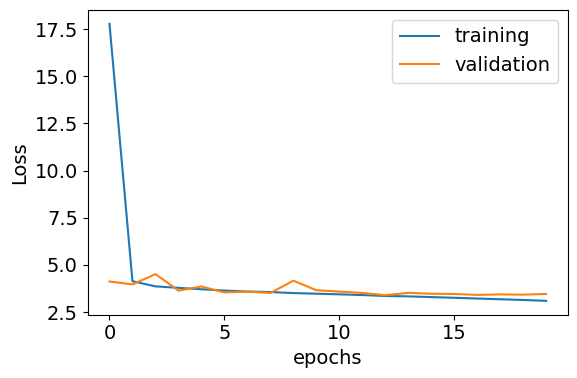

In [63]:
plot_loss(20, train_losses, val_losses,figsize=(6, 4))



In [64]:
tdeltas = evaluate_cnn(test_loader, model, device, pixel_size = 6, energy=False)

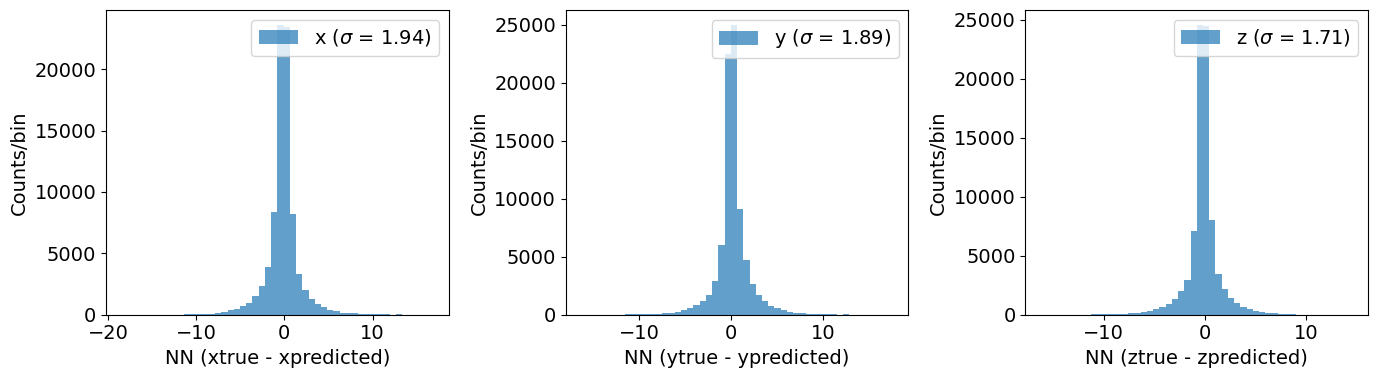

In [65]:
plotxyz(tdeltas, nbins=50)